In [127]:
import requests
import numpy as np
import pandas as pd
from matplotlib.dates import HourLocator, DateFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal, interpolate
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import copernicusmarine
import os, fnmatch

In [3]:
def download_cmems_data(dataset, start_date, end_date, output_directory):
    """
    Downloads CMEMS NetCDF data for the given date range, or uses existing files if available.

    Parameters:
        dataset (str): CMEMS dataset ID.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        output_directory (str): Directory to save downloaded files.

    Returns:
        list: List of file paths for the downloaded or existing NetCDF files.
    """
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    files_append = []

    while current_date <= end_date:
        date_str = current_date.strftime("%Y%m%d")
        filename_pattern = f"*{date_str}_*.nc"

        # Check for files matching the pattern in the output directory
        local_files = [
            os.path.join(output_directory, f)
            for f in os.listdir(output_directory)
            if fnmatch.fnmatch(f, filename_pattern)
        ]
        #print(local_files)
        if not local_files:  # If no matching file exists locally, download it
            get_results = copernicusmarine.get(
                dataset_id=dataset,
                filter=filename_pattern,
                no_directories=True,
                force_download=True,
                output_directory=output_directory
            )
            files_append.extend(get_results)
        else:
            # Append only unique matching files to the list
            files_append.extend(local_files)

        current_date += timedelta(days=1)

    # Ensure the list of files is unique
    files_append = list(set(files_append))

    return files_append


In [31]:
output_directory = "./"
dataset = 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i'
start_date = "2024-12-21" #"2024-12-01"
end_date = "2024-12-24" #"2024-12-04"

files = download_cmems_data(dataset, start_date, end_date, output_directory)


WARNING - 2024-12-26T00:14:13Z - Deprecation warning for option 'force_download'. This option will no longer be available in copernicusmarine>=2.0.0. Please refer to the documentation when the new major version is released for more information.
Fetching catalog: 100%|██████████| 3/3 [01:22<00:00, 27.34s/it]
INFO - 2024-12-26T00:15:41Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2024-12-26T00:15:41Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-12-26T00:15:41Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-12-26T00:15:41Z - Downloading using service original-files...
100%|██████████| 1/1 [00:28<00:00, 28.44s/it]
WARNING - 2024-12-26T00:16:13Z - Deprecation warning for option 'force_download'. This option will no longer be available in copernicusmarine>=2.0.0. Please refer to the documentation when the new major version is released for more information.
INFO - 2024-12-26T0

[PosixPath('SMOC_20241222_R20241223.nc'), PosixPath('SMOC_20241223_R20241224.nc'), PosixPath('SMOC_20241224_R20241225.nc'), PosixPath('SMOC_20241221_R20241222.nc')]


In [45]:
print(files)

[PosixPath('SMOC_20241222_R20241223.nc'), PosixPath('SMOC_20241223_R20241224.nc'), PosixPath('SMOC_20241224_R20241225.nc'), PosixPath('SMOC_20241221_R20241222.nc')]


In [46]:
# Function to compose CMEMS data into a single DataFrame
def compose_cmems_dataframe(files, lon, lat):
    frames = []
    for file in files:
        ds = xr.open_dataset(file)
        selected = ds.sel(longitude=lon, latitude=lat, method="nearest")
        u = selected["utide"].values.flatten() * 100  # Convert to cm/s
        v = selected["vtide"].values.flatten() * 100  # Convert to cm/s
        timestamps = pd.to_datetime(selected["time"].values)

        frames.append(pd.DataFrame({"timestamp": timestamps, "u": u, "v": v}))
    
    # Combine all frames into one DataFrame
    return pd.concat(frames).reset_index(drop=True).sort_values(by='timestamp', ascending=True)

# Function to fetch data from your API
def fetch_tide_api(lon, lat, start, end, variables=["u", "v"]):
    base_url = "https://eco.odb.ntu.edu.tw/api/tide"
    params = {
        "lon0": lon,
        "lat0": lat,
        "start": start,
        "end": end,
        "append": ",".join(variables)
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    return response.json()

# Function to filter and align timestamps
def compare_and_filter(api_df, cmems_df, cmems_adjusted):
    """
    Filter and align API and CMEMS data for comparison.

    Parameters:
        api_df (pd.DataFrame): API data with columns ["timestamp", "u", "v"].
        cmems_df (pd.DataFrame): Original CMEMS data.
        cmems_adjusted (pd.DataFrame): Adjusted or interpolated CMEMS data.

    Returns:
        pd.DataFrame: Comparison dataframe with aligned timestamps.
    """
    # Ensure timestamps are in UTC
    api_df["timestamp"] = pd.to_datetime(api_df["timestamp"]).dt.tz_convert("UTC")
    cmems_adjusted["timestamp"] = pd.to_datetime(cmems_adjusted["timestamp"]).dt.tz_convert("UTC")

    # Determine the overlapping time range
    min_time = max(api_df["timestamp"].min(), cmems_adjusted["timestamp"].min())
    max_time = min(api_df["timestamp"].max(), cmems_adjusted["timestamp"].max())

    # Filter API and CMEMS data within the overlapping time range
    api_filtered = api_df[(api_df["timestamp"] >= min_time) & (api_df["timestamp"] <= max_time)]
    cmems_filtered = cmems_adjusted[(cmems_adjusted["timestamp"] >= min_time) & (cmems_adjusted["timestamp"] <= max_time)]

    # Prepare comparison dataframe
    comparison_df = pd.DataFrame({
        "timestamp": api_filtered["timestamp"],
        "u_api": api_filtered["u"],
        "v_api": api_filtered["v"],
        "u_cmems": cmems_filtered["u"].values,
        "v_cmems": cmems_filtered["v"].values
    })
    return comparison_df


# Calculate phase difference
def calculate_phase_difference(signal1, signal2):
    correlation = signal.correlate(signal1 - np.mean(signal1), signal2 - np.mean(signal2), mode='full')
    lags = signal.correlation_lags(len(signal1), len(signal2), mode='full')
    lag = lags[np.argmax(correlation)]
    return lag

# Plot statistics
def plot_statistics(comparison_df):
    plt.figure(figsize=(12, 8))
    
    # Plot U-component differences
    plt.subplot(2, 1, 1)
    plt.plot(comparison_df["timestamp"], comparison_df["u_api"], label="API u")
    plt.plot(comparison_df["timestamp"], comparison_df["u_cmems"], label="CMEMS u")
    plt.fill_between(comparison_df["timestamp"], comparison_df["u_api"], comparison_df["u_cmems"], alpha=0.2)
    plt.title("Comparison of U-Component (Tidal Current)")
    plt.xlabel("Time")
    plt.ylabel("U-Component (cm/s)")
    plt.legend()
    
    # Plot V-component differences
    plt.subplot(2, 1, 2)
    plt.plot(comparison_df["timestamp"], comparison_df["v_api"], label="API v")
    plt.plot(comparison_df["timestamp"], comparison_df["v_cmems"], label="CMEMS v")
    plt.fill_between(comparison_df["timestamp"], comparison_df["v_api"], comparison_df["v_cmems"], alpha=0.2)
    plt.title("Comparison of V-Component (Tidal Current)")
    plt.xlabel("Time")
    plt.ylabel("V-Component (cm/s)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [47]:
lon, lat = 122.1, 24.85 #124.781, 33.475
cmems_df = compose_cmems_dataframe(files, lon, lat)


In [48]:
print(cmems_df[0:50 :])

             timestamp         u         v
72 2024-12-21 00:30:00  8.984375  0.683594
73 2024-12-21 01:30:00  8.984375  1.855469
74 2024-12-21 02:30:00  7.324219  2.636719
75 2024-12-21 03:30:00  4.003906  2.734375
76 2024-12-21 04:30:00 -0.195312  1.660156
77 2024-12-21 05:30:00 -4.296875 -0.488281
78 2024-12-21 06:30:00 -7.617188 -3.027344
79 2024-12-21 07:30:00 -9.375000 -4.882812
80 2024-12-21 08:30:00 -9.277344 -5.468750
81 2024-12-21 09:30:00 -7.519531 -4.785156
82 2024-12-21 10:30:00 -4.785156 -3.222656
83 2024-12-21 11:30:00 -1.660156 -1.269531
84 2024-12-21 12:30:00  1.171875  0.878906
85 2024-12-21 13:30:00  3.222656  2.929688
86 2024-12-21 14:30:00  4.003906  4.589844
87 2024-12-21 15:30:00  3.417969  5.566406
88 2024-12-21 16:30:00  1.757812  5.371094
89 2024-12-21 17:30:00 -0.292969  3.906250
90 2024-12-21 18:30:00 -2.050781  1.464844
91 2024-12-21 19:30:00 -2.832031 -0.976562
92 2024-12-21 20:30:00 -2.343750 -2.539062
93 2024-12-21 21:30:00 -0.683594 -2.929688
94 2024-12-

In [79]:
start = "2024-12-21T00:00:00Z" #"2024-11-30T23:00:00Z" #slightly earlier than start_date
end = "2024-12-25T00:00:00Z" #"2024-12-05T00:00:00Z" #slightly later than end_date

# Fetch data from API
api_data = fetch_tide_api(lon, lat, start, end, variables=["u", "v"])
api_df = pd.DataFrame({
    "timestamp": pd.to_datetime(api_data["time"]),
    "u": api_data["u"],
    "v": api_data["v"]
})

In [80]:
print(api_df[0:50])

                   timestamp         u         v
0  2024-12-21 00:00:00+00:00  2.714839 -2.503210
1  2024-12-21 01:00:00+00:00  3.658345  1.779641
2  2024-12-21 02:00:00+00:00  3.933487  5.807086
3  2024-12-21 03:00:00+00:00  3.500357  8.581502
4  2024-12-21 04:00:00+00:00  2.499218  9.433723
5  2024-12-21 05:00:00+00:00  1.176608  8.167694
6  2024-12-21 06:00:00+00:00 -0.197525  5.083561
7  2024-12-21 07:00:00+00:00 -1.380104  0.896390
8  2024-12-21 08:00:00+00:00 -2.174715 -3.424405
9  2024-12-21 09:00:00+00:00 -2.451349 -6.871922
10 2024-12-21 10:00:00+00:00 -2.183555 -8.642788
11 2024-12-21 11:00:00+00:00 -1.482784 -8.347680
12 2024-12-21 12:00:00+00:00 -0.589009 -6.122950
13 2024-12-21 13:00:00+00:00  0.201992 -2.594384
14 2024-12-21 14:00:00+00:00  0.647064  1.302636
15 2024-12-21 15:00:00+00:00  0.641365  4.584242
16 2024-12-21 16:00:00+00:00  0.236818  6.471338
17 2024-12-21 17:00:00+00:00 -0.404359  6.563903
18 2024-12-21 18:00:00+00:00 -1.079607  4.908736
19 2024-12-21 19:00:

In [83]:
def adjust_cmems_timestamps(cmems_df, api_df, adjustment="interpolate", scale=1.0):
    """
    Adjust CMEMS timestamps for comparison with API data.

    Parameters:
        cmems_df (pd.DataFrame): CMEMS data with columns ["timestamp", "u", "v"].
        api_df (pd.DataFrame): API data with columns ["timestamp", "u", "v"].
        adjustment (str): Method to adjust CMEMS timestamps. Options:
                          "interpolate" - Interpolate CMEMS data to match API timestamps.
                          "delay+1"     - Shift CMEMS timestamps by +1 hour.
                          "delay-1"     - Shift CMEMS timestamps by -1 hour.

    Returns:
        pd.DataFrame: Adjusted CMEMS data with aligned timestamps.
    """
    api_filtered = api_df.copy()
    cmems_filtered = cmems_df.copy()

    # Ensure both timestamps are UTC
    api_filtered["timestamp"] = pd.to_datetime(api_filtered["timestamp"]).dt.tz_convert("UTC")
    cmems_filtered["timestamp"] = pd.to_datetime(cmems_filtered["timestamp"]).dt.tz_localize("UTC")

    if adjustment == "delay+1":
        # Shift CMEMS timestamps forward by 1 hour
        cmems_filtered["timestamp"] += pd.Timedelta(hours=0.5)
        cmems_filtered["u"] *= scale  # Convert m/s to cm/s
        cmems_filtered["v"] *= scale  # Convert m/s to cm/s
    elif adjustment == "delay-1":
        # Shift CMEMS timestamps backward by 1 hour
        cmems_filtered["timestamp"] -= pd.Timedelta(hours=0.5)
        cmems_filtered["u"] *= scale  # Convert m/s to cm/s
        cmems_filtered["v"] *= scale  # Convert m/s to cm/s
    elif adjustment == "interpolate":
        # Convert timestamps to numeric values for interpolation
        cmems_times = cmems_filtered["timestamp"].astype(np.int64) // 10**9
        api_times = api_filtered["timestamp"].astype(np.int64) // 10**9

        # Check and scale the data
        cmems_filtered["u"] *= scale # Convert m/s to cm/s
        cmems_filtered["v"] *= scale

        # Create interpolation functions for u and v
        u_interp = interpolate.interp1d(
            cmems_times,
            cmems_filtered["u"],  
            kind="linear",
            fill_value="extrapolate"
        )
        v_interp = interpolate.interp1d(
            cmems_times,
            cmems_filtered["v"],  
            kind="linear",
            fill_value="extrapolate"
        )

        # Interpolate CMEMS data to match API timestamps
        return pd.DataFrame({
            "timestamp": api_filtered["timestamp"],
            "u": u_interp(api_times),
            "v": v_interp(api_times)
        })

    # Align timestamps for delay adjustments
    cmems_filtered = cmems_filtered.set_index("timestamp")
    cmems_adjusted = (
        cmems_filtered.reindex(api_filtered["timestamp"])
        .reset_index()
    )
    return cmems_adjusted

In [84]:
cmems_interpolated = adjust_cmems_timestamps(cmems_df, api_df, adjustment="interpolate", scale=1.0)
print(cmems_interpolated)

                   timestamp         u         v
0  2024-12-21 00:00:00+00:00  8.984375  0.097656
1  2024-12-21 01:00:00+00:00  8.984375  1.269531
2  2024-12-21 02:00:00+00:00  8.154297  2.246094
3  2024-12-21 03:00:00+00:00  5.664062  2.685547
4  2024-12-21 04:00:00+00:00  1.904297  2.197266
..                       ...       ...       ...
92 2024-12-24 20:00:00+00:00  1.123047  2.929688
93 2024-12-24 21:00:00+00:00 -1.171875  1.123047
94 2024-12-24 22:00:00+00:00 -2.978516 -0.732422
95 2024-12-24 23:00:00+00:00 -3.955078 -2.099609
96 2024-12-25 00:00:00+00:00 -4.443359 -3.173828

[97 rows x 3 columns]


In [85]:
comparison_df = compare_and_filter(api_df, cmems_df, cmems_interpolated)

print(comparison_df[0:50])

                   timestamp     u_api     v_api   u_cmems   v_cmems
0  2024-12-21 00:00:00+00:00  2.714839 -2.503210  8.984375  0.097656
1  2024-12-21 01:00:00+00:00  3.658345  1.779641  8.984375  1.269531
2  2024-12-21 02:00:00+00:00  3.933487  5.807086  8.154297  2.246094
3  2024-12-21 03:00:00+00:00  3.500357  8.581502  5.664062  2.685547
4  2024-12-21 04:00:00+00:00  2.499218  9.433723  1.904297  2.197266
5  2024-12-21 05:00:00+00:00  1.176608  8.167694 -2.246094  0.585938
6  2024-12-21 06:00:00+00:00 -0.197525  5.083561 -5.957031 -1.757812
7  2024-12-21 07:00:00+00:00 -1.380104  0.896390 -8.496094 -3.955078
8  2024-12-21 08:00:00+00:00 -2.174715 -3.424405 -9.326172 -5.175781
9  2024-12-21 09:00:00+00:00 -2.451349 -6.871922 -8.398438 -5.126953
10 2024-12-21 10:00:00+00:00 -2.183555 -8.642788 -6.152344 -4.003906
11 2024-12-21 11:00:00+00:00 -1.482784 -8.347680 -3.222656 -2.246094
12 2024-12-21 12:00:00+00:00 -0.589009 -6.122950 -0.244141 -0.195312
13 2024-12-21 13:00:00+00:00  0.20

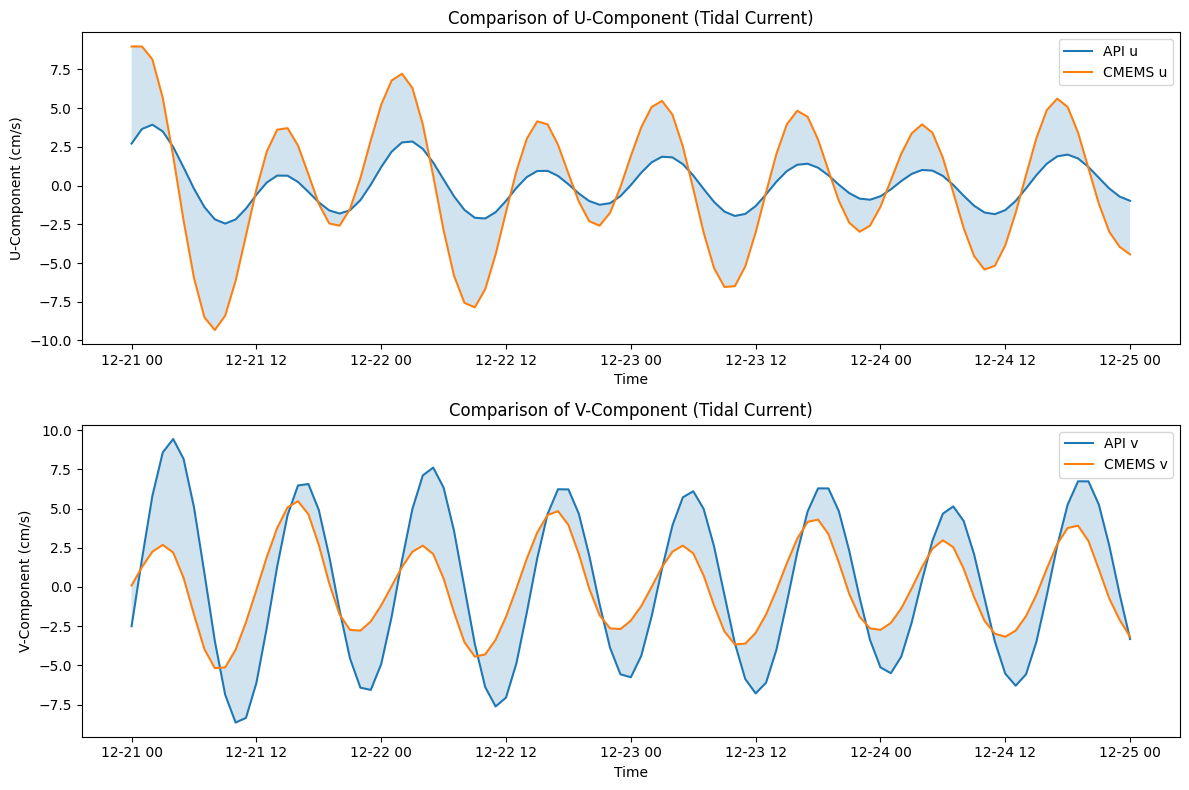

In [86]:
# Plot results
plot_statistics(comparison_df)

In [136]:
# Old code from simu_target_tideapi01.ipynb
# Calculate phase difference using cross-correlation
def calculate_phase_difference(signal1, signal2):
    """
    Calculate phase difference between two signals using cross-correlation.
    
    Parameters:
        signal1 (array-like): First signal.
        signal2 (array-like): Second signal.
    
    Returns:
        float: Phase difference in hours.
    """
    correlation = signal.correlate(signal1 - np.mean(signal1), signal2 - np.mean(signal2), mode='full')
    lags = signal.correlation_lags(len(signal1), len(signal2), mode='full')
    lag = lags[np.argmax(correlation)]
    return lag  # Lag is in number of samples

# Custom formatter for tick labels
def custom_date_formatter(x, pos):
    # Convert the x value (in Matplotlib date format) to a readable datetime
    dt = mdates.num2date(x)
    hour = dt.strftime("%H")
    if hour == "00":  # Keep full date for "00"
        return dt.strftime("%m-%d %H")
    else:  # Only show the hour for other ticks
        return hour
    
def two_tides_compare(comparison_df, phase_diff_hours_u, phase_diff_hours_v, target_name="CMEMS", 
                      lon=None, lat=None, start_date=None, end_date=None, place_name=None):
    """
    Plot comparisons between two tidal datasets for u and v components with annotations.
    
    Parameters:
        comparison_df (pd.DataFrame): DataFrame with timestamps, u, and v components for both datasets.
        phase_diff_hours_u (float): Phase difference in hours for the u-component.
        phase_diff_hours_v (float): Phase difference in hours for the v-component.
        target_name (str): Name of the comparison dataset (e.g., "CMEMS").
        lon (float): Longitude of the comparison location.
        lat (float): Latitude of the comparison location.
        start_date (str): Start date of the comparison.
        end_date (str): End date of the comparison.
        place_name (str): Optional place name for the location.
    """
    plt.figure(figsize=(14, 10))

    # Annotation text
    location_info = f"Coordinates: ({lat:.3f}, {lon:.3f})"
    place_info = f"Location: {place_name}" if place_name else ""
    duration_info = f"Duration: {start_date} to {end_date}"
    cmems_info = "CMEMS: cmems_mod_glo_phy_anfc_merged-uv_PT1H-i"
    if place_name:
        annotate_text = f"{location_info}\n{place_info}\n{duration_info}\n{cmems_info}"
    else:
        annotate_text = f"{location_info}\n{duration_info}\n{cmems_info}"

    # U-component comparison
    plt.subplot(2, 1, 1)
    plt.plot(comparison_df["timestamp"], comparison_df["u_api"], label="ODB Tide API u")
    plt.plot(comparison_df["timestamp"], comparison_df["u_cmems"], label="CMEMS utide")
    plt.fill_between(comparison_df["timestamp"], comparison_df["u_api"] - comparison_df["u_cmems"],
                     comparison_df["u_api"] + comparison_df["u_cmems"], alpha=0.2)
    plt.xlabel("Time")
    plt.ylabel("U-Component (cm/s)")
    plt.legend(loc="upper right")
    plt.title(f"Comparison of U-Component (Tidal Current)\nPhase Difference: {phase_diff_hours_u:.2f} hours")
    plt.text(0.02, 0.95, annotate_text, 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment="top", 
             horizontalalignment="left", bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

    # V-component comparison
    plt.subplot(2, 1, 2)
    plt.plot(comparison_df["timestamp"], comparison_df["v_api"], label="ODB Tide API v")
    plt.plot(comparison_df["timestamp"], comparison_df["v_cmems"], label="CMEMS vtide")
    plt.fill_between(comparison_df["timestamp"], comparison_df["v_api"] - comparison_df["v_cmems"],
                     comparison_df["v_api"] + comparison_df["v_cmems"], alpha=0.2)
    plt.xlabel("Time")
    plt.ylabel("V-Component (cm/s)")
    plt.legend(loc="upper right")
    plt.title(f"Comparison of V-Component (Tidal Current)\nPhase Difference: {phase_diff_hours_v:.2f} hours")
    plt.text(0.02, 0.95, annotate_text, 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment="top", 
             horizontalalignment="left", bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

    # Adjust x-axis ticks to every 6 hours, starting from 00:00
    for ax in plt.gcf().axes:
    #     ax.xaxis.set_major_locator(HourLocator(byhour=[0, 6, 12, 18], interval=1))
    #     ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H"))
    #      ax.tick_params(axis="x", rotation=45)
    # Adjust x-axis ticks to show specific hours with dates only on midnight ticks
    # for ax in plt.gcf().axes:
    #     ax.xaxis.set_major_locator(HourLocator(byhour=[0, 6, 12, 18], interval=1))
    #     ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H"))
    #     ax.xaxis.set_minor_formatter(DateFormatter("%H"))
    # Not work    
    #    # Remove the date part from minor ticks at 06, 12, and 18
    #    for label in ax.get_xticklabels():
    #        if "00" not in label.get_text():
    #            label.set_text(label.get_text()[6:])  # Remove the date portion
      ax.xaxis.set_major_locator(HourLocator(byhour=[0, 6, 12, 18], interval=1))
      # Set the custom formatter
      ax.xaxis.set_major_formatter(FuncFormatter(custom_date_formatter))


    plt.tight_layout()
    plt.show()



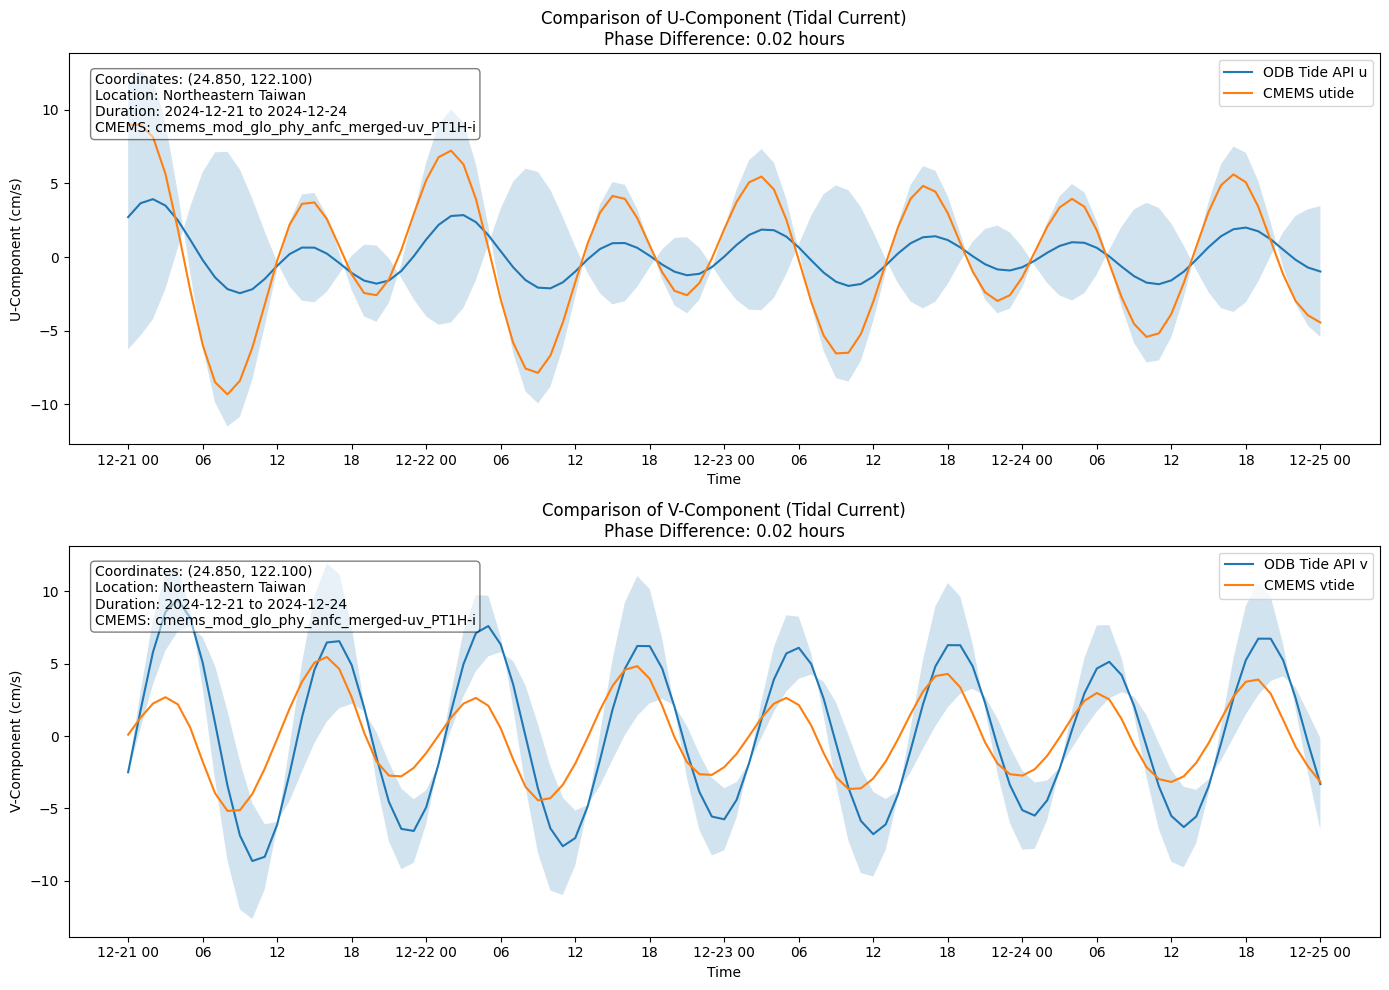

In [137]:
# Calculate phase differences
phase_diff_u = calculate_phase_difference(comparison_df["u_api"].values, comparison_df["u_cmems"].values)
phase_diff_v = calculate_phase_difference(comparison_df["v_api"].values, comparison_df["v_cmems"].values)

# Convert lag to hours
phase_diff_hours_u = phase_diff_u / 60  # Assuming 1 sample = 1 minute
phase_diff_hours_v = phase_diff_v / 60  # Assuming 1 sample = 1 minute

# Plot comparisons
two_tides_compare(comparison_df, phase_diff_hours_u, phase_diff_hours_v, target_name="CMEMS", 
                  lon=lon, lat=lat, start_date=start_date, end_date=end_date, place_name="Northeastern Taiwan")


In [138]:
def compare_tide_api_cmems(lon, lat, start, end, cmems_dir='./', method='interpolate', dataset='cmems_mod_glo_phy_anfc_merged-uv_PT1H-i', place_name=None):
    """
    Compare tidal current data from the Tide API and CMEMS datasets.

    Parameters:
        lon (float): Longitude of the location.
        lat (float): Latitude of the location.
        start (str): Start date in "YYYY-MM-DD" format.
        end (str): End date in "YYYY-MM-DD" format.
        cmems_dir (str): Directory for CMEMS files.
        method (str): Adjustment method for CMEMS timestamps: 'interpolate', 'delay+1', or 'delay-1'.
        dataset (str): CMEMS dataset ID.
        place_name (str): Optional place name for the location.

    Returns:
        None. The function plots the comparison results.
    """
    try:
        # Step 1: Download and compose CMEMS data
        print(f"Downloading CMEMS data from {start} to {end}...")
        cmems_files = download_cmems_data(dataset, start, end, cmems_dir)
        cmems_df = compose_cmems_dataframe(cmems_files, lon, lat)
        
        # Step 2: Adjust API fetch time to start earlier and end later
        api_start = (pd.to_datetime(start) - pd.Timedelta(hours=1)).strftime("%Y-%m-%dT%H:%M:%SZ")
        api_end = (pd.to_datetime(end) + pd.Timedelta(hours=1)).strftime("%Y-%m-%dT%H:%M:%SZ")
        
        print(f"Fetching Tide API data from {api_start} to {api_end}...")
        api_data = fetch_tide_api(lon, lat, api_start, api_end, variables=["u", "v"])
        
        # Step 3: Create API DataFrame
        api_df = pd.DataFrame({
            "timestamp": pd.to_datetime(api_data["time"]),
            "u": api_data["u"],
            "v": api_data["v"]
        })
        
        # Step 4: Adjust CMEMS timestamps and interpolate (if needed)
        print(f"Adjusting CMEMS timestamps using method: {method}...")
        cmems_interpolated = adjust_cmems_timestamps(cmems_df, api_df, adjustment=method, scale=1.0)  # Convert m/s to cm/s
        
        # Step 5: Compare and filter overlapping time ranges
        print("Filtering and aligning overlapping time ranges...")
        comparison_df = compare_and_filter(api_df, cmems_df, cmems_interpolated)
        
        if comparison_df.empty:
            raise ValueError("No overlapping data found after filtering. Check the date ranges and data availability.")
        
        # Step 6: Calculate phase differences
        print("Calculating phase differences...")
        phase_diff_u = calculate_phase_difference(comparison_df["u_api"].values, comparison_df["u_cmems"].values)
        phase_diff_v = calculate_phase_difference(comparison_df["v_api"].values, comparison_df["v_cmems"].values)
        
        # Convert lag to hours
        phase_diff_hours_u = phase_diff_u / 60  # Assuming 1 sample = 1 minute
        phase_diff_hours_v = phase_diff_v / 60  # Assuming 1 sample = 1 minute
        
        # Step 7: Plot comparisons
        print("Plotting comparison results...")
        two_tides_compare(comparison_df, phase_diff_hours_u, phase_diff_hours_v, target_name="CMEMS",
                          lon=lon, lat=lat, start_date=start, end_date=end, place_name=place_name)
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise


Fetching Tide API data from 2024-12-20T23:00:00Z to 2024-12-24T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


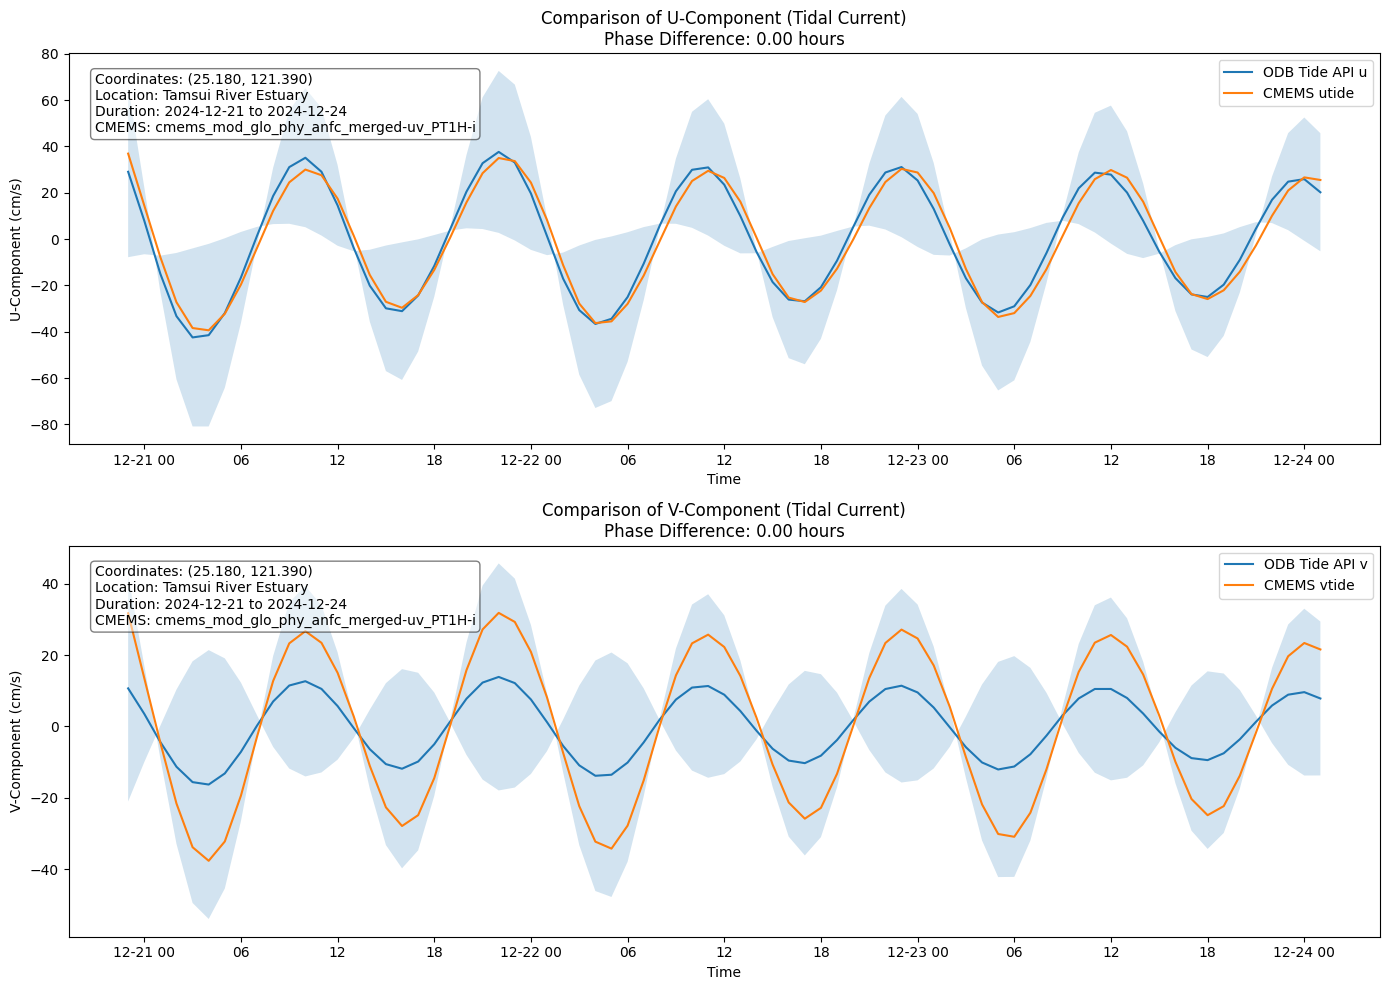

In [157]:
compare_tide_api_cmems(
    lon=121.39,
    lat=25.18,
    start="2024-12-21",
    end="2024-12-24",
    cmems_dir="./",
    method="interpolate",
    place_name="Tamsui River Estuary"
)

Fetching Tide API data from 2024-12-20T23:00:00Z to 2024-12-24T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


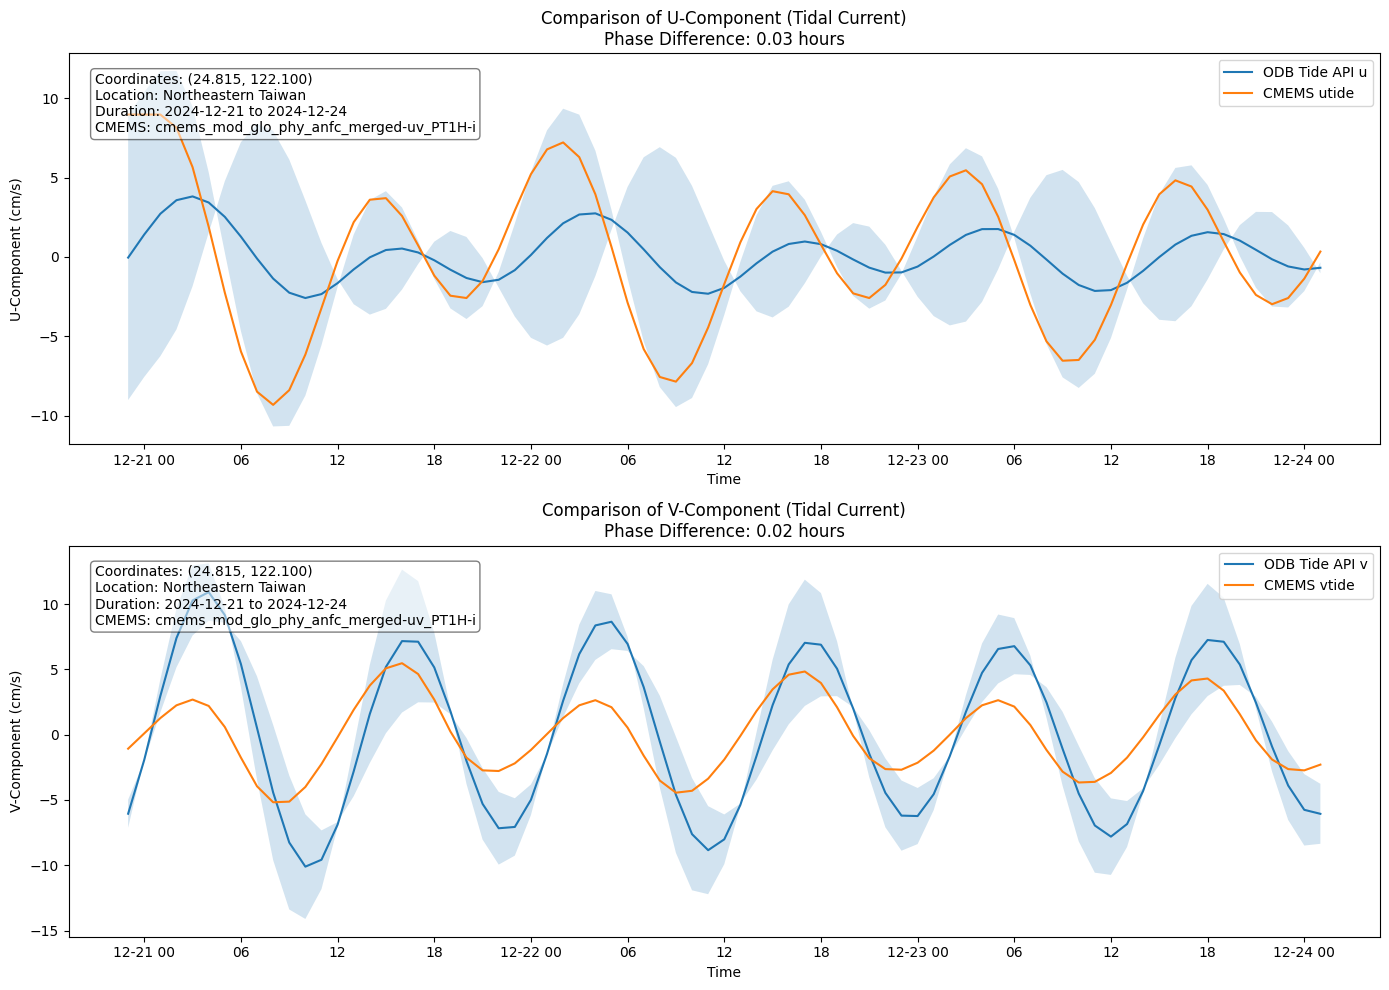

In [ ]:
compare_tide_api_cmems(
    lon=122.1,
    lat=24.815,
    start="2024-12-21",
    end="2024-12-24",
    cmems_dir="./",
    method="interpolate",
    place_name="Northeastern Taiwan"
)

Fetching Tide API data from 2024-12-20T23:00:00Z to 2024-12-24T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


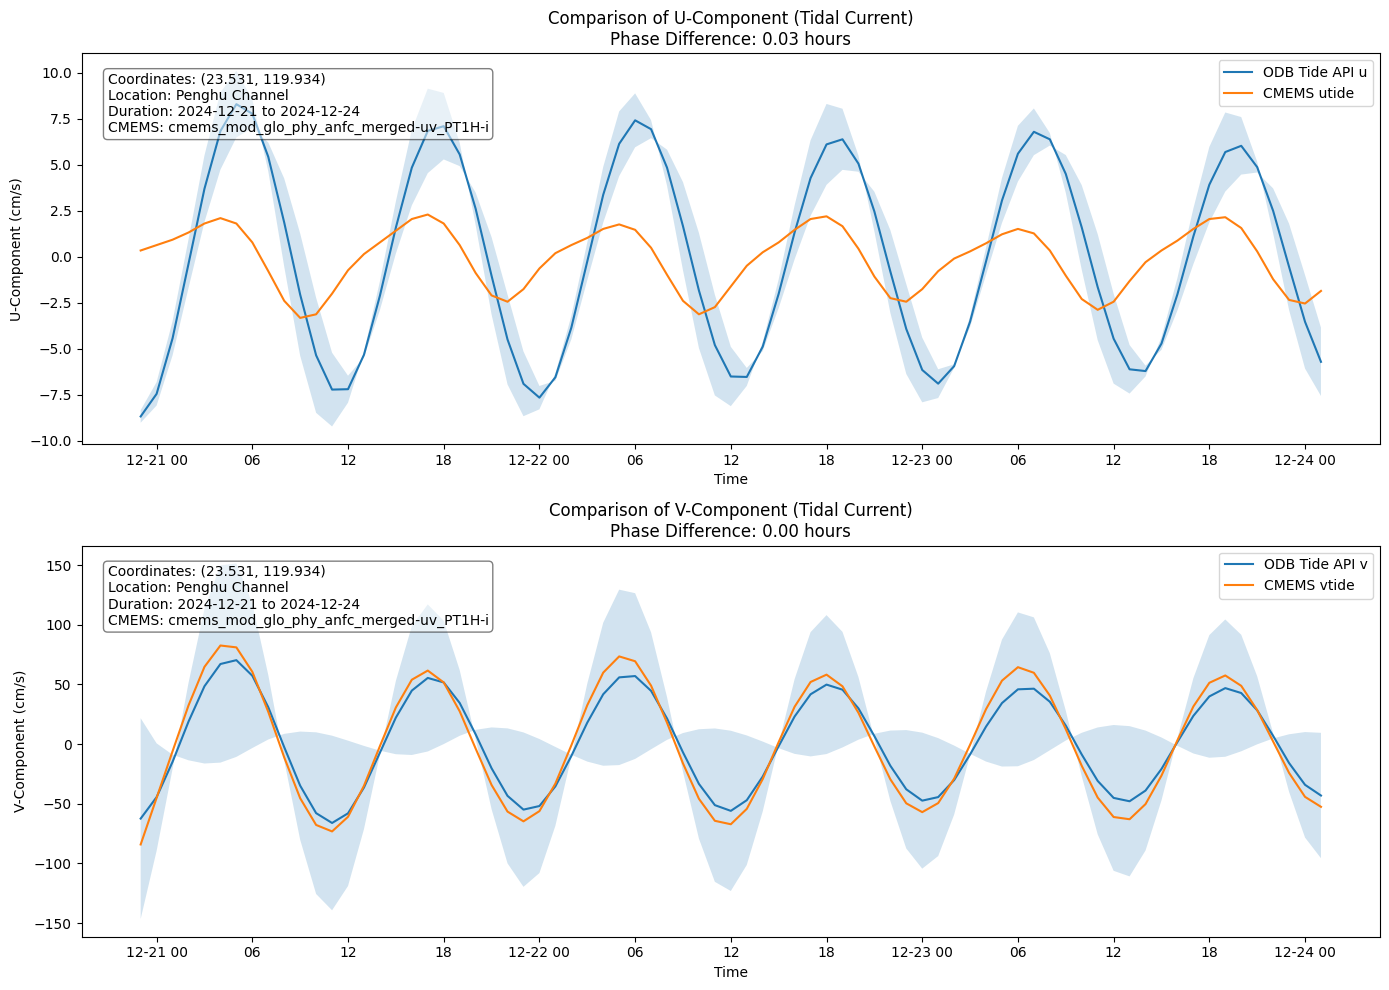

In [147]:
compare_tide_api_cmems(
    lon=119.934,
    lat=23.531,
    start="2024-12-21",
    end="2024-12-24",
    cmems_dir="./",
    method="interpolate",
    place_name="Penghu Channel"
)

Fetching Tide API data from 2024-12-20T23:00:00Z to 2024-12-24T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


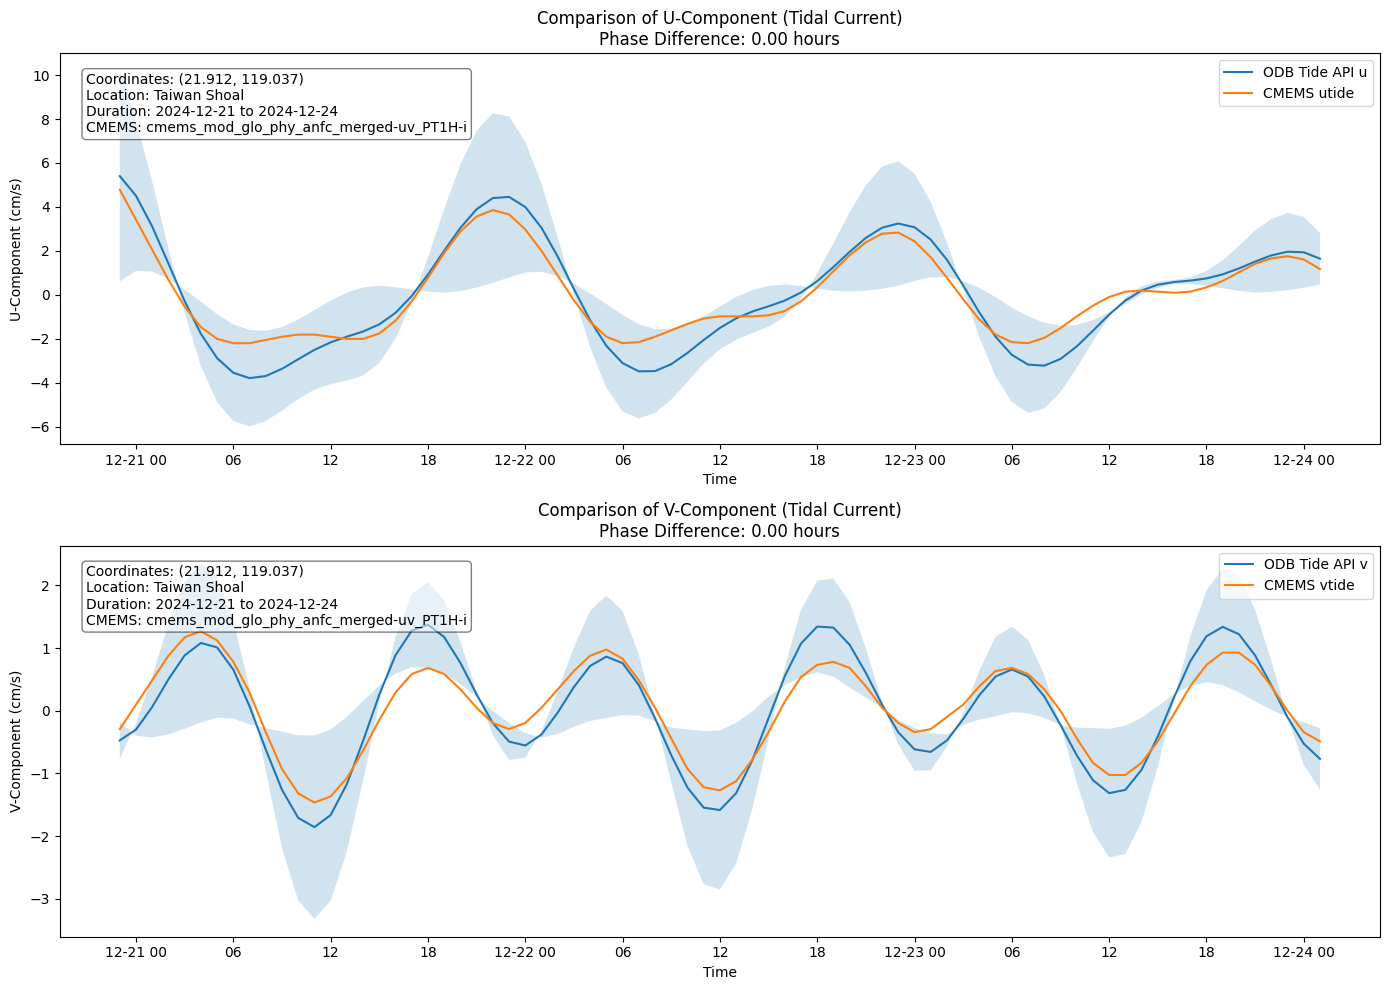

In [142]:
compare_tide_api_cmems(
    lon=119.037,
    lat=21.912,
    start="2024-12-21",
    end="2024-12-24",
    cmems_dir="./",
    method="interpolate" ,
    place_name="Taiwan Shoal"
)

Fetching Tide API data from 2024-12-20T23:00:00Z to 2024-12-24T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


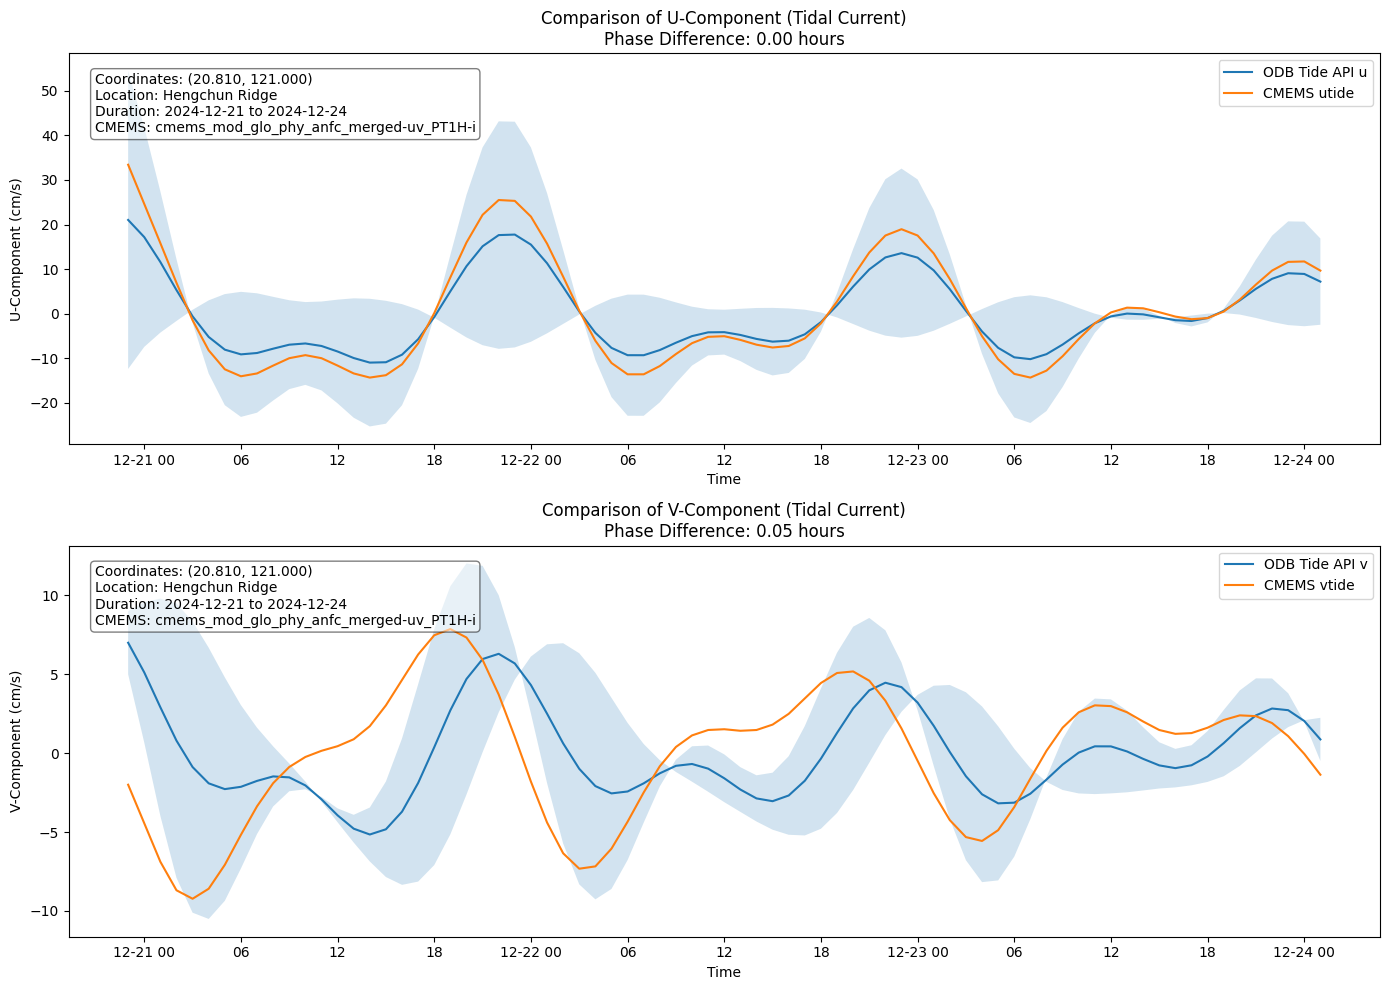

In [ ]:
compare_tide_api_cmems(
    lon=121,
    lat=20.81,
    start="2024-12-21",
    end="2024-12-24",
    cmems_dir="./",
    method="interpolate",
    place_name="Hengchun Ridge"
)

Fetching Tide API data from 2024-12-20T23:00:00Z to 2024-12-24T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


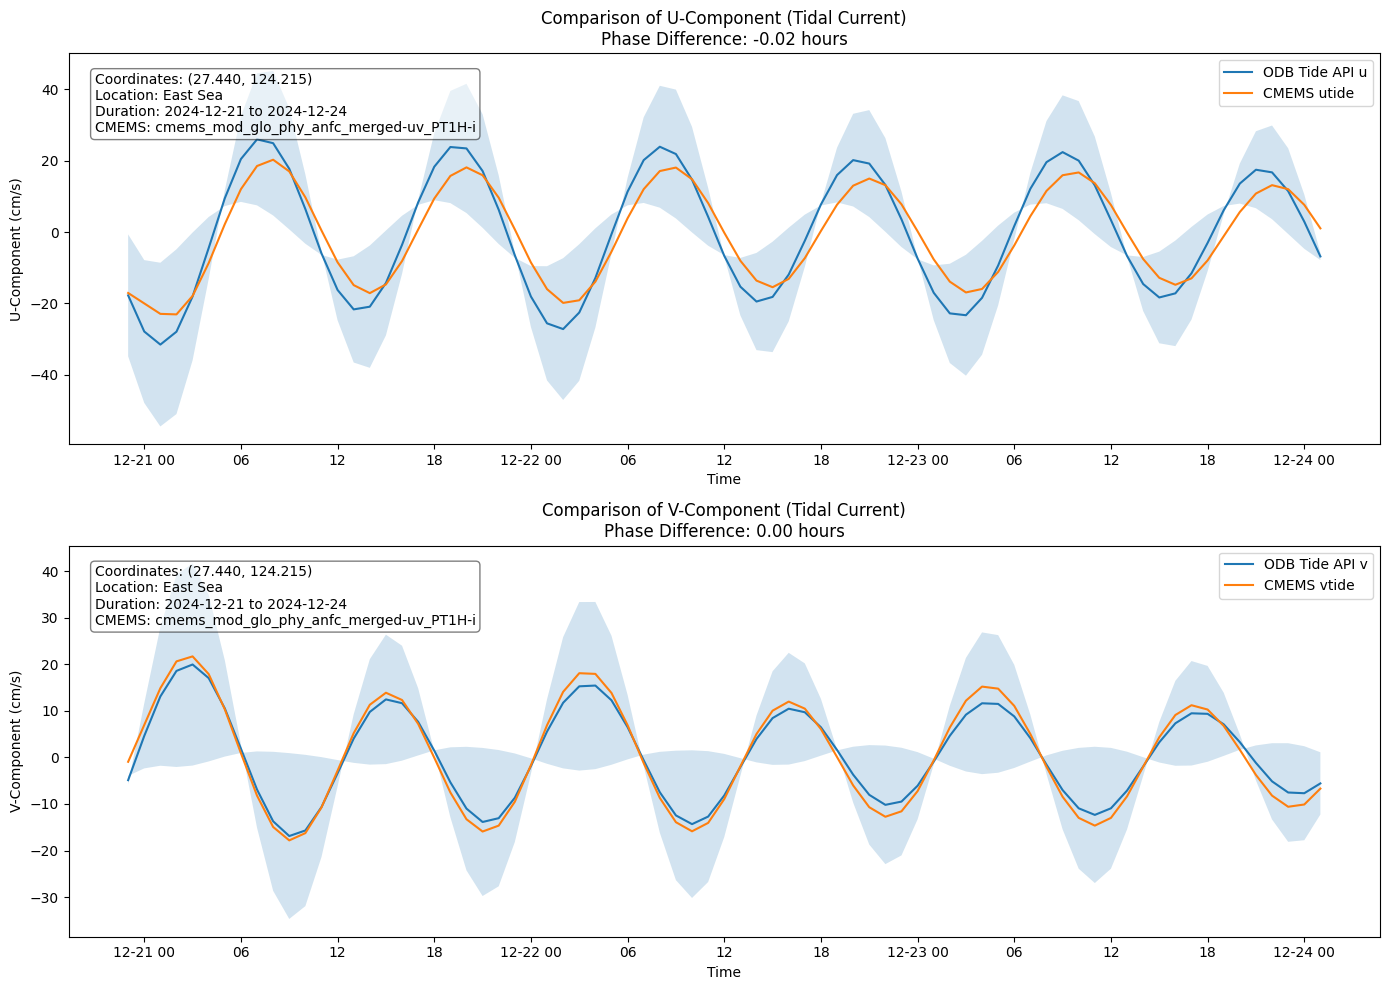

In [ ]:
compare_tide_api_cmems(
    lon=124.215,
    lat=27.44,
    start="2024-12-21",
    end="2024-12-24",
    cmems_dir="./",
    method="interpolate",
    place_name="East Sea"
)

Fetching Tide API data from 2024-12-20T23:00:00Z to 2024-12-24T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


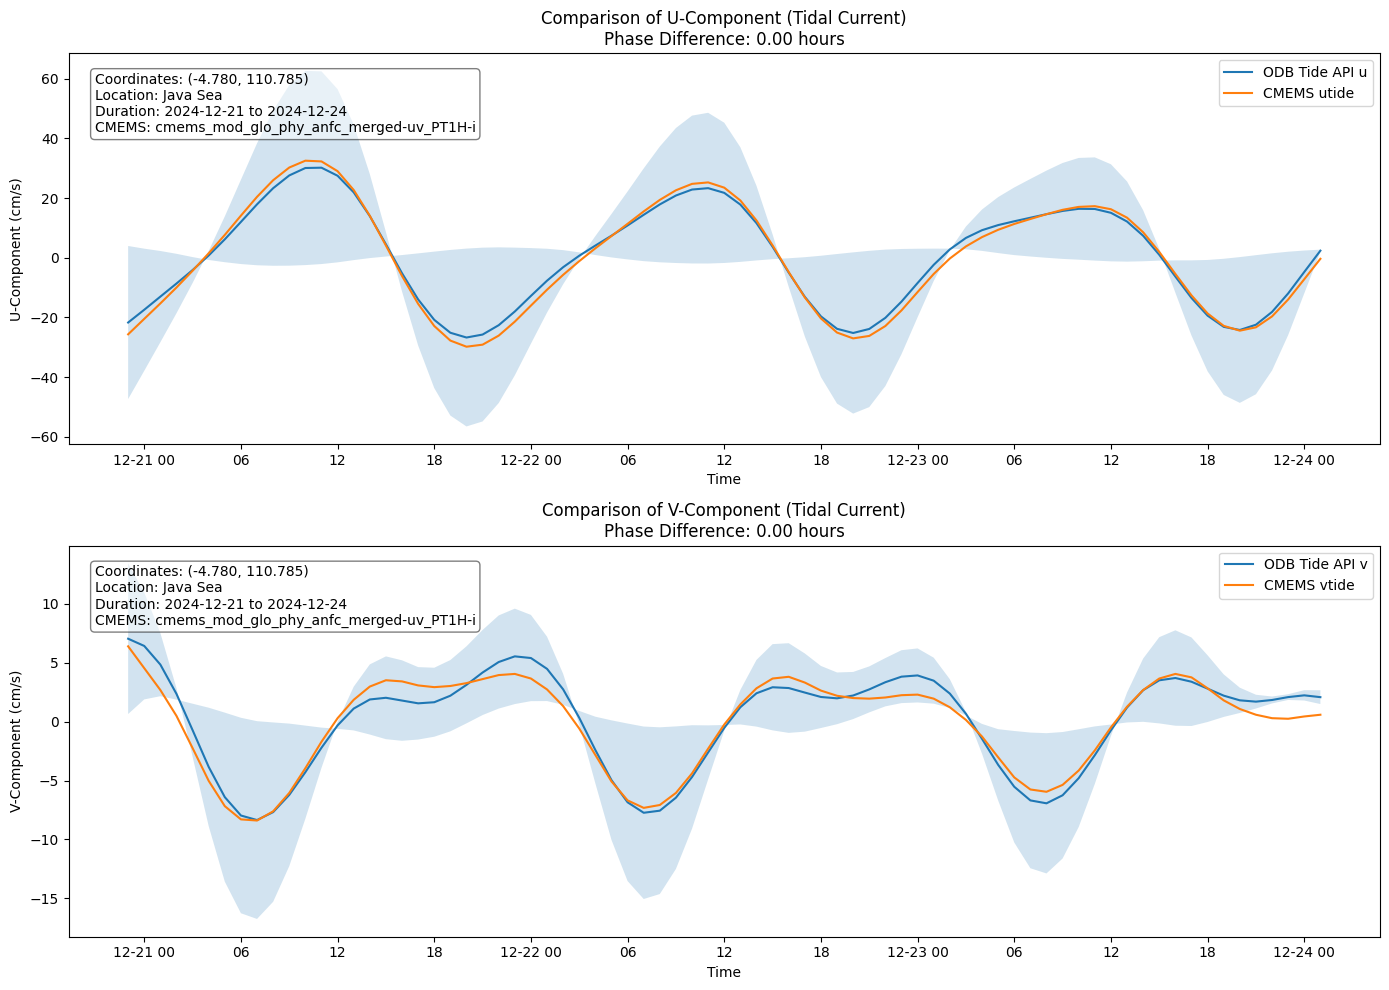

In [ ]:
compare_tide_api_cmems(
    lon=110.785,
    lat=-4.78,
    start="2024-12-21",
    end="2024-12-24",
    cmems_dir="./",
    method="interpolate",
    place_name="Java Sea",
)

Fetching Tide API data from 2024-12-20T23:00:00Z to 2024-12-24T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


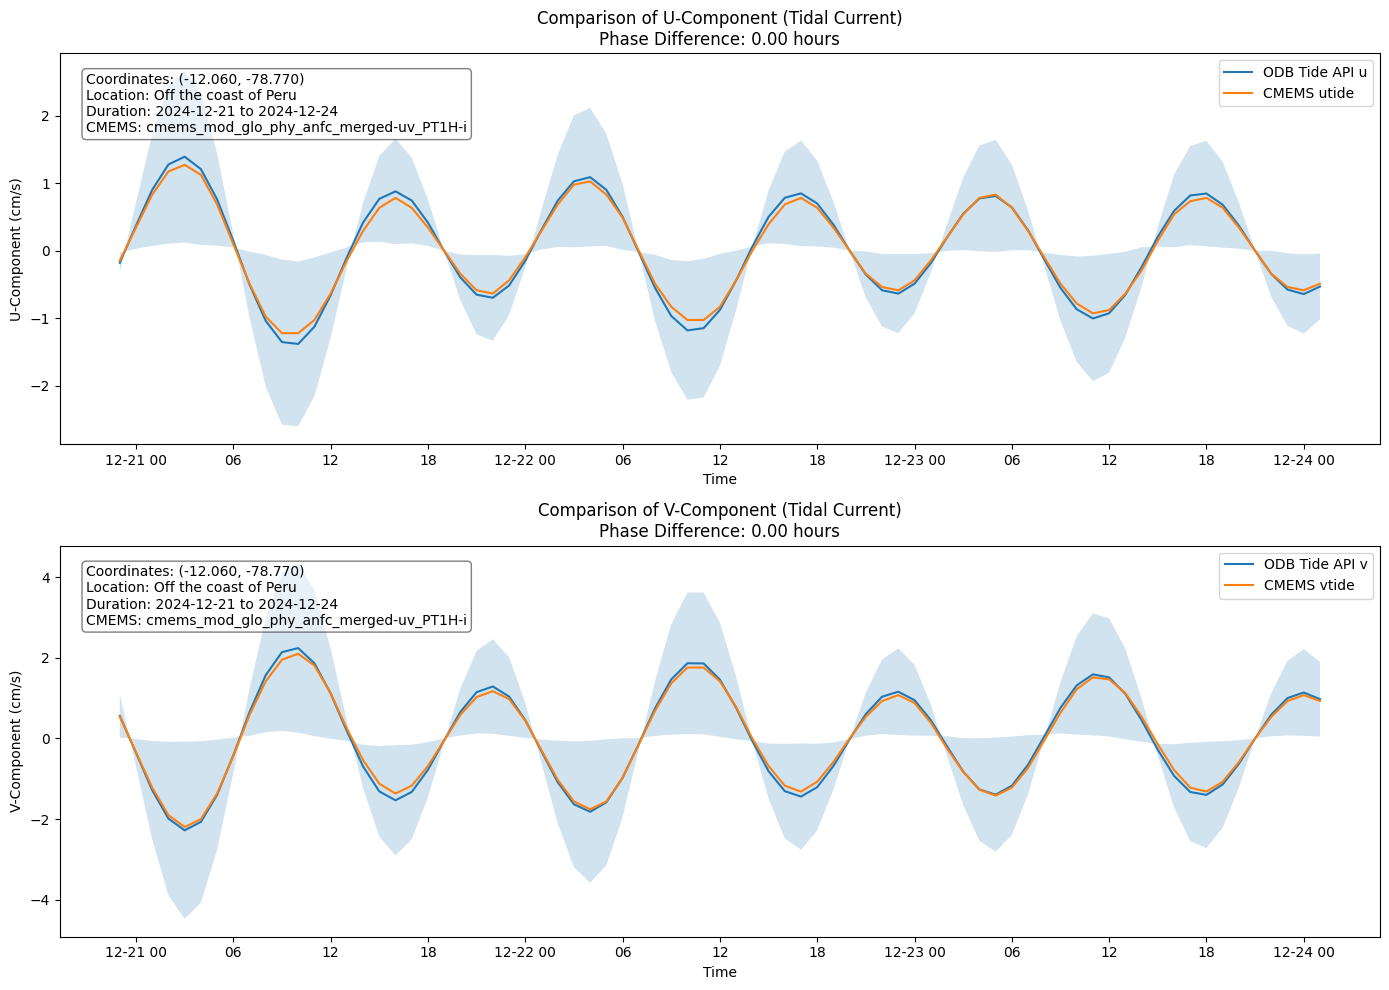

In [154]:
compare_tide_api_cmems(
    lon=-78.770,
    lat=-12.06,
    start="2024-12-21",
    end="2024-12-24",
    cmems_dir="./",
    method="interpolate",
    place_name="Off the coast of Peru",
)

Fetching Tide API data from 2024-12-20T23:00:00Z to 2024-12-24T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


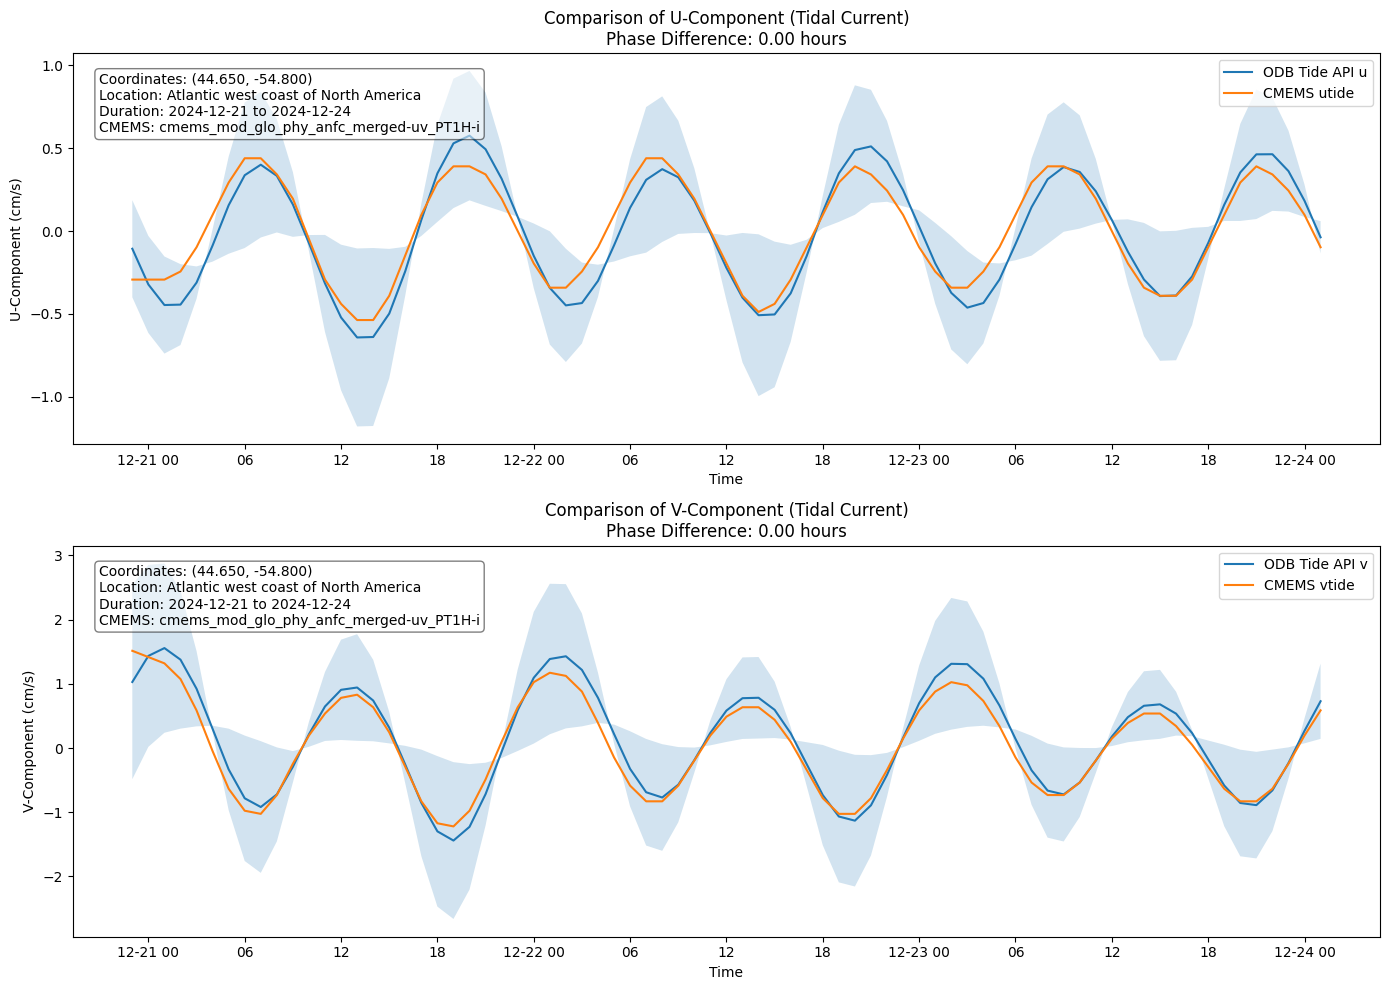

In [ ]:
compare_tide_api_cmems(
    lon=-54.80,
    lat=44.65,
    start="2024-12-21",
    end="2024-12-24",
    cmems_dir="./",
    method="interpolate",
    place_name="Atlantic west coast of North America",
)

Fetching Tide API data from 2024-12-20T23:00:00Z to 2024-12-24T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


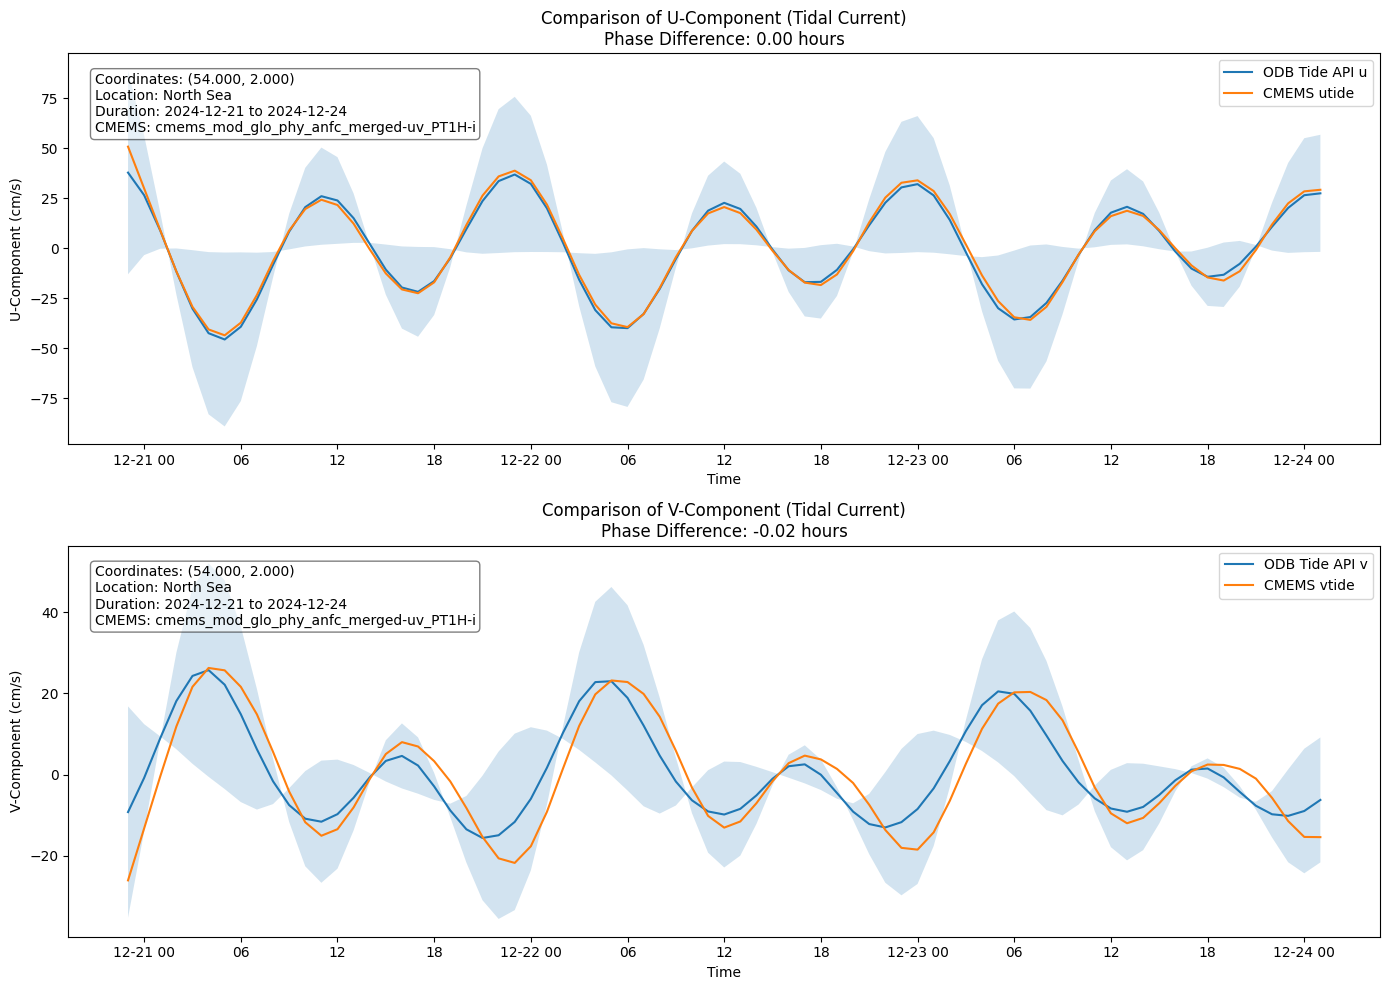

In [144]:
compare_tide_api_cmems(
    lon=2,
    lat=54,
    start="2024-12-21",
    end="2024-12-24",
    cmems_dir="./",
    method="interpolate",
    place_name="North Sea"
)


Fetching Tide API data from 2024-12-20T23:00:00Z to 2024-12-24T01:00:00Z...
Adjusting CMEMS timestamps using method: interpolate...
Filtering and aligning overlapping time ranges...
Calculating phase differences...
Plotting comparison results...


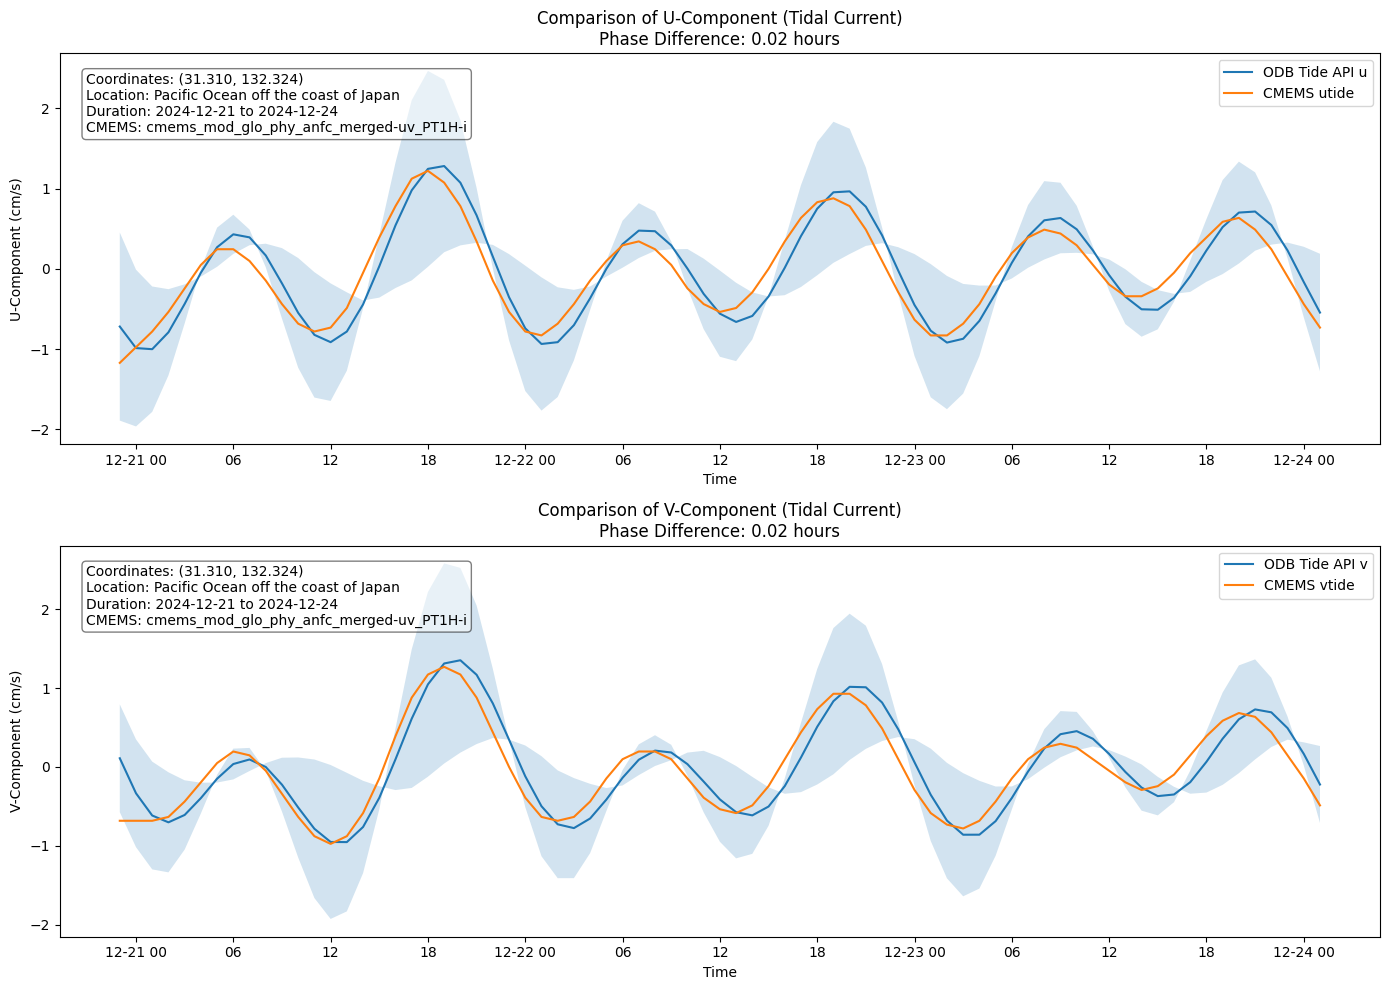

In [145]:
compare_tide_api_cmems(
    lon=132.324,
    lat=31.31,
    start="2024-12-21",
    end="2024-12-24",
    cmems_dir="./",
    method="interpolate",
    place_name="Pacific Ocean off the coast of Japan"
)

In [ ]:
#Other test （Read files)
# Fetch CMEMS data
ds = xr.open_dataset("./SMOC_20241201_R20241202.nc")
print(ds)

<xarray.Dataset> Size: 7GB
Dimensions:    (longitude: 4320, latitude: 2041, depth: 1, time: 24)
Coordinates:
  * longitude  (longitude) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9
  * latitude   (latitude) float32 8kB -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * depth      (depth) float32 4B 0.494
  * time       (time) datetime64[ns] 192B 2024-12-01T00:30:00 ... 2024-12-01T...
Data variables:
    utotal     (time, depth, latitude, longitude) float32 846MB ...
    vtotal     (time, depth, latitude, longitude) float32 846MB ...
    utide      (time, depth, latitude, longitude) float32 846MB ...
    vtide      (time, depth, latitude, longitude) float32 846MB ...
    uo         (time, depth, latitude, longitude) float32 846MB ...
    vo         (time, depth, latitude, longitude) float32 846MB ...
    vsdx       (time, depth, latitude, longitude) float32 846MB ...
    vsdy       (time, depth, latitude, longitude) float32 846MB ...
Attributes:
    producer:                      CMEMS -